# Introduction

In this article, I will introduce another approach to Collaborative Filtering based on Matrix Factorization (or Matrix Decomposition).

Recall that in Content-based Recommendation Systems, each item is described by a vector $x$ is called the item profile. In this method, we need to find a coefficient vector $w$ corresponding to each user such that the known rating that user gives the item is approximately equal to:

$$y \approx w^T x$$

Then we will have Ultility Matrix

$$Y \approx \begin{bmatrix} x_1w_1 & x_2w_2 & \cdots & x_1w_n \\ x_2w_1 & x_2w_2 & \cdots & x_2w_n \\ \vdots & \vdots & \ddots & \vdots \\ x_mw_1 & x_mw_2 & \cdots & x_mw_n \end{bmatrix} = \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_m \end{bmatrix} \begin{bmatrix} w_1 & w_2 & \cdots & w_n \end{bmatrix} = XW$$

With M, N is the number of users and items respectively.

Note that $x$ is constructed based on the item description information and this construction process is independent of the process of finding the appropriate coefficient for each user. Thus, the construction of the item profile plays a very important role and has a direct impact on the performance of the model. In addition, constructing each individual model for each user leads to poor results because it does not exploit the characteristics of similar users.

Now, suppose that we do not need to construct the profile items $x$ in advance, but the feature vector for each item can be trained simultaneously with the model for each user (here a coefficient vector). This means that the variables in the optimization problem are both $X$ and $W$. Where $X$ is a matrix of every item profile, each row is a feature vector of an item, and $W$ is a matrix of every user coefficient, each row is a coefficient vector of a user.

With this, we are trying to find the best approximation of the utility matrix $Y \in \mathbb{R}^{M \times N}$ by the product of two matrices $X \in \mathbb{R}^{M \times K}$ and $W \in \mathbb{R}^{K \times N}$, where $K$ is the number of latent features.

Typically, $K$ can be much smaller than $M$ and $N$. Then both matrix $X$ and $W$ are low-rank matrices (rank smaller than $K$). This is the main idea of Low-Rank Matrix Factorization.

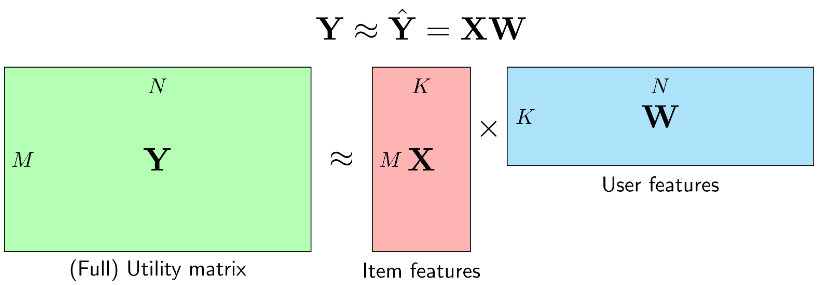

Some notes:
- Matrix Factorization describes the relationship between latent features of items and users. The higher the correlation coefficient of features between items and users, the more likely the item is to be a good match for the user.
- Matrix Factorization is classified as Collaborative Filtering because it is based on optimizing the relationship between matrices X (items) and W (users). Each row/column in these matrices corresponds to the features of users and items, and through optimization, this method helps predict the interaction between them.
- A major difference between Matrix Factorization and Neighborhood-based Collaborative Filtering is that Matrix Factorization needs to perform machine learning to find the optimal matrix, while Neighborhood-based directly uses the similarity index between items/users to predict.
- Matrix Factorization is more memory-efficient because it only stores the X and W matrices instead of the entire Similarity matrix like Neighborhood-based Collaborative Filtering. (Only need $K(M + N)$ not $M^2$ or $N^2$ in similarity matrix)

# Build and Optimize loss function

### Loss function

Similar to Content-based Recommendation Systems, the construction of the loss function is also based on the filled components of the Utility Matrix $Y$, the only difference is that there is no bias component and the optimal variable is both $X$ and $W$:

$$\mathcal{L}(X, W) = \frac{1}{2s} \sum_{n = 1}^N \sum_{m : r_{mn} = 1} (y_{mn} - x_mw_n)^2 + \frac{\lambda}{2}(||X||^2 + ||W||^2) \tag{1}$$

Where:
- $r_{mn}$ is the indicator function, $r_{mn} = 1$ if user $m$ has rated item $n$.
- $s$ is the number of filled components in the Utility Matrix $Y$.

***Note***: The ratings are usually normalized, by subtracting each row of the Utility Matrix from the average of the known values ​​in that row (item-based) or subtracting each column from the average of the known values ​​in that column (user-based). In certain cases, normalization of this matrix is ​​not necessary, but additional techniques are required to address the problem of bias in the ratings.

Simultaneous optimization of $X$, $W$ is relatively complicated, instead, the method used is to sequentially optimize one matrix while fixing the other, until convergence.

### Optimization

When fix $X$, to optimize $W$, we have the following optimization problem:

$$\mathcal{L}(W) = \frac{1}{2s} \sum_{n = 1}^N \sum_{m : r_{mn} = 1} (y_{mn} - x_mw_n)^2 + \frac{\lambda}{2}||W||^2 \tag{2}$$

When fix $W$, to optimize $X$, we have:

$$\mathcal{L}(X) = \frac{1}{2s} \sum_{m = 1}^M \sum_{n : r_{mn} = 1} (y_{mn} - x_mw_n)^2 + \frac{\lambda}{2}||X||^2 \tag{3}$$

We can see that problem $(2)$ can be split into $N$ smaller problems, each problem is to find the optimal coefficient vector for each item $W$:

$$\mathcal{L}(w_n) = \frac{1}{2s} \sum_{m : r_{mn} = 1} (y_{mn} - x_mw_n)^2 + \frac{\lambda}{2}||w_n||^2 \tag{4}$$

Because the $\sum$ only depends on items that user $m$ has rated, we can simplify it by set $\hat{X}_n$ is the matrix created by each row of $X$ that corresponds to the items that user $m$ has rated, then:

$$\mathcal{L}(w_n) = \frac{1}{2s} ||\hat{y}_n - \hat{X}_n w_n||^2 + \frac{\lambda}{2}||w_n||^2 \tag{5}$$

And the derivative:

$$\frac{\partial \mathcal{L}(w_n)}{\partial w_n} = -\frac{1}{s} \hat{X}_n^T (\hat{y}_n - \hat{X}_n w_n) + \lambda w_n \tag{6}$$

Then the update rule for $w_n$ is:

$$w_n = w_n - \eta \left( -\frac{1}{s} \hat{X}_n^T (\hat{y}_n - \hat{X}_n w_n) + \lambda w_n \right) \tag{7}$$

Same with each columns of $X$:

$$\mathcal{L}(x_m) = \frac{1}{2s} \sum_{n : r_{mn} = 1} (y_{mn} - x_mw_n)^2 + \frac{\lambda}{2}||x_m||^2 \tag{8}$$

Set $\hat{W}_m$ is the matrix created by each row of $W$ that corresponds to the users that item $n$ has rated and $\hat{y}^m$ is vector rating, then $(8)$ will be:

$$\mathcal{L}(x_m) = \frac{1}{2s} ||\hat{y}^m - x_m \hat{W}_m||^2 + \frac{\lambda}{2}||x_m||^2 \tag{9}$$

Then to update $x_m$:

$$x_m = x_m - \eta \left( -\frac{1}{s} \hat{W}_m^T (\hat{y}^m - x_m \hat{W}_m) + \lambda x_m \right) \tag{10}$$

# Conclusion

### When have bias

One advantage of the Matrix Factorization approach for Collaborative Filtering is its flexibility to include additional constraints, which may be related to the data processing or to the specific application.

Suppose we do not normalize the ratings values ​​but use their initial values ​​directly in the equation $(1)$. Normalization can also be built directly into the loss function. As I mentioned, real ratings are biased by users and/or items. There are easy and difficult users, and there are also items that are rated higher than others simply because the user sees that other users have rated the item highly. The bias problem can be solved by using variables called biases, which are user and item dependent and can be optimized together with $X$ and $W$.

$$y_{mn} \approx x_mw_n + b_m + d_n + \mu$$

Where:
- $b_m$ is the bias of user $m$.
- $d_n$ is the bias of item $n$.
- $\mu$ is the global bias.

Then the loss function will be:

$$\mathcal{L}(X, W, b, d) = \frac{1}{2s} \sum_{n = 1}^N \sum_{m : r_{mn} = 1} (y_{mn} - x_mw_n - b_m - d_n - \mu)^2 + \frac{\lambda}{2}(||X||^2 + ||W||^2 + ||b||^2 + ||d||^2) \tag{11}$$

### Non-negative Matrix Factorization

When the data is not normalized, they all have non-negative values. If the range of ratings contains negative values, we just need to add a reasonable value to the Utility Matrix to get ratings that are non-negative numbers. At that time, another Matrix Factorization method that is also widely used and highly effective in Recommendation Systems is Nonnegative Matrix Factorization, which is to analyze the matrix into a product of matrices with non-negative elements.

By Matrix Factorization, users and items are linked together by latent features (latent properties). The association of each user and item to each latent feature is measured by the corresponding component in their coefficient feature vector, the larger the value, the more relevant the user or item is to that latent feature. Intuitively, the association of a user or item to a latent feature should be a non-negative number with a value of 0 representing no association. Furthermore, each user and item is only related to a certain latent feature. So the feature vectors for users and items should be non-negative vectors and have a lot of zero values. These solutions can be achieved by adding a non-negative constraint to the components of the When the data is not normalized, they all have non-negative values. If the range of ratings contains negative values, we just need to add a reasonable value to the Utility Matrix to get ratings that are non-negative numbers. In that case, another Matrix Factorization method that is also widely used and highly effective in Recommendation Systems is Nonnegative Matrix Factorization, which is to decompose the matrix into a product of matrices with non-negative elements.

By Matrix Factorization, users and items are linked together by latent features. The degree of association of each user and item to each latent feature is measured by the corresponding component in their coefficient feature vector, the larger the value, the more relevant the user or item is to that latent feature. Intuitively, the relevance of a user or item to a latent feature should be nonnegative, with zero representing no relevance. Furthermore, each user and item should be relevant to only a few latent features. Thus, the feature vectors for users and items should be nonnegative and have a large number of zeros. These solutions can be achieved by adding nonnegativity constraints to the components of $X$ and $W$

### Incremental Matrix Factorization

As mentioned, the inference time of Recommendation Systems using Matrix Factorization is very fast but the training time is quite long with large data sets. In reality, the Utility Matrix changes continuously because there are new users, items as well as new ratings or users want to change their ratings, so the two matrices $X$ and $W$ need to be updated continuously. Incremental Matrix Factorization is a method that updates the matrices $X$ and $W$ incrementally, instead of retraining the entire model from scratch. This method is very useful in real-time Recommendation Systems.